In [1]:
import numpy as np 
import pandas as pd 
import anndata as ad 
import scanpy as sc 
import matplotlib.pyplot as plt 

# Description 

This notebook is used to generate a fine annotation for excitatory neuron. We will use the Logistic Regression model to predict the label.

## Load multiome data and scRNA-seq data

In [ ]:
## load raw data

scdata = sc.read_h5ad('/home/rsun@ZHANGroup.local/sly_data/celltype_check/modify_multi.h5ad')

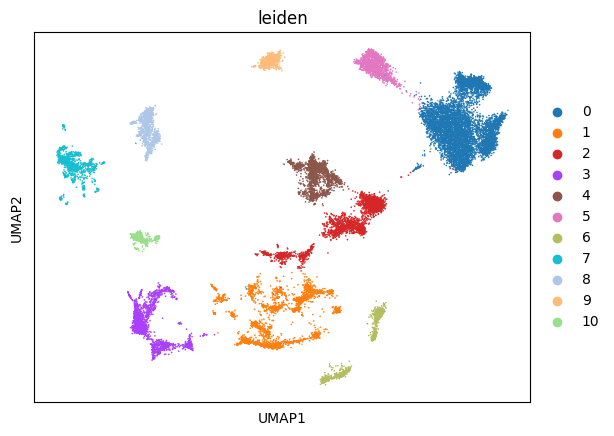

In [3]:
sc.pl.umap(scdata, color = ['leiden'])

In [4]:
## load rna data 
rna = sc.read_h5ad('ex_neuron.h5ad')
rna

AnnData object with n_obs × n_vars = 27320 × 23848
    obs: 'samples', 'state', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'new_leiden', 'new_anno', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [8]:
mutual_gene = np.intersect1d(rna.var.index, scdata.var.index)
print(mutual_gene.shape) 

sc_var = scdata.var.copy()
scdata.var = sc_var 
scdata = scdata[:,mutual_gene] 

rna = rna[:,mutual_gene]
print(rna.shape, scdata.shape)


(9911,)
(27320, 9911) (21861, 9911)


## train a classifier based on multiome data

分类报告：
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       663
           1       0.95      0.96      0.95       293
          10       0.95      0.91      0.93        43
           2       0.95      0.87      0.91       267
           3       0.90      0.94      0.92       189
           4       0.93      0.93      0.93       191
           5       0.97      0.94      0.95       127
           6       0.97      0.95      0.96       132
           7       0.96      0.97      0.96       125
           8       0.96      0.93      0.94        98
           9       0.92      0.92      0.92        59

    accuracy                           0.94      2187
   macro avg       0.94      0.93      0.94      2187
weighted avg       0.94      0.94      0.94      2187

混淆矩阵：


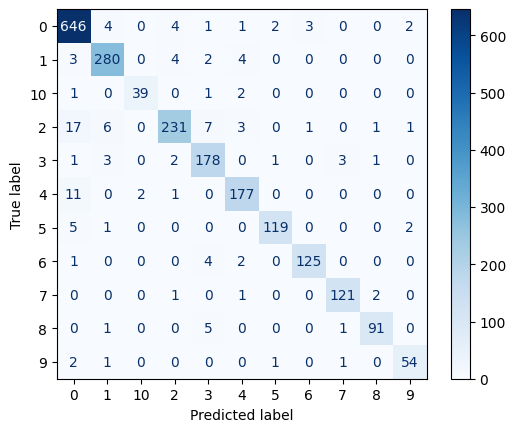

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression



X = scdata.X.toarray() 
y = scdata.obs.leiden.astype(str)


# 将字符串标签编码为整数
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 编码后的标签

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.1, random_state=42
)

# 训练随机森林分类器
#rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
#rf_classifier.fit(X_train, y_train)
model = LogisticRegression() 
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 将预测结果解码回原始字符串标签
y_test_decoded = label_encoder.inverse_transform(y_test)  # 真实标签
y_pred_decoded = label_encoder.inverse_transform(y_pred)  # 预测标签

# 打印分类报告
print("分类报告：")
print(classification_report(y_test_decoded, y_pred_decoded))

# 打印混淆矩阵
print("混淆矩阵：")
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.show()


## predict scrna cell type

In [ ]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna) 

pred_X = rna.X.toarray() 

#pred_prob = rf_classifier.predict_proba(pred_X)
#print(pred_prob.shape) 

pred_label = model.predict(pred_X)#np.argmax(pred_prob, axis=1) 
pred_label = label_encoder.inverse_transform(pred_label) 

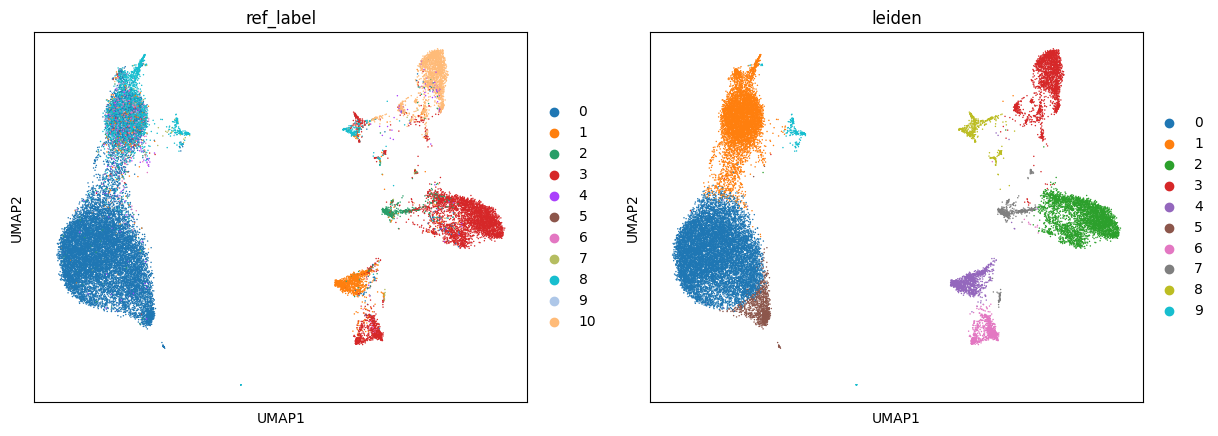

In [18]:
sc.pl.umap(rna, color = ['ref_label', 'leiden'])

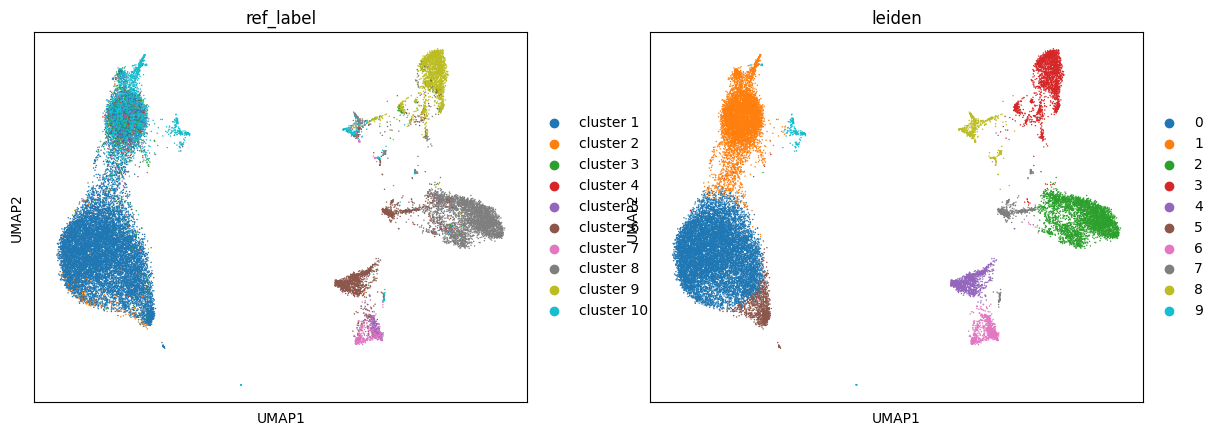

In [ ]:
sc.pp.neighbors(rna, use_rep = 'X_pca_harmony')

sc.tl.umap(rna, min_dist = 0.1)
#sc.tl.leiden(rna, resolution = 0.1)
#sc.pl.umap(rna, color = ['leiden'])

rna.obs.loc[:,'ref_label'] = pred_label 

sc.tl.leiden(rna, resolution = 0.6)
sc.pl.umap(rna, color = ['ref_label', 'leiden'])

In [13]:
pd.crosstab(rna.obs.leiden, columns = rna.obs.ref_label)

ref_label,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10
leiden,,,,,,,,,,
0,10692,193,64,37,18,26,0,4,2,37
1,1381,2,555,176,544,157,1,64,8,3165
2,9,1,5,11,7,110,0,3352,3,2
3,8,1,48,2,4,56,4,88,1898,6
4,2,4,6,1,10,1166,6,18,2,1
5,921,78,14,0,1,3,0,2,1,1
6,5,1,1,0,247,81,559,13,0,0
7,0,0,0,1,4,475,6,69,0,52
8,0,0,7,0,6,75,28,167,81,222


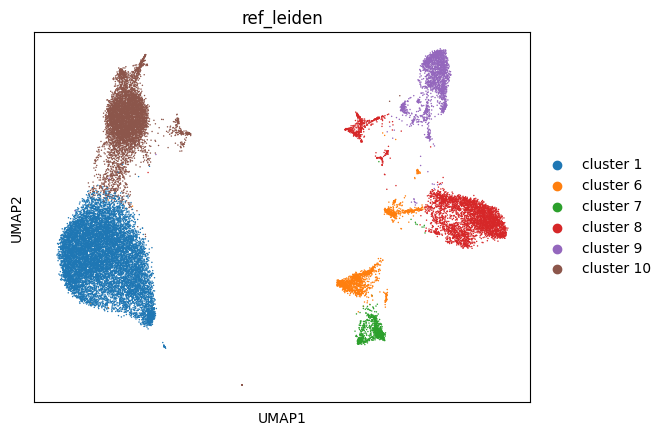

In [15]:
ref_dic = {'0': 'cluster 1',
           '1': 'cluster 10',
           '2': 'cluster 8',
           '3': 'cluster 9',
           '4': 'cluster 6',
           '5': 'cluster 1',
           '6': 'cluster 7',
           '7': 'cluster 6',
           '8': 'cluster 8',
           '9': 'cluster 10'
    }
rna.obs.loc[:,'ref_leiden'] = rna.obs.leiden.map(ref_dic)
sc.pl.umap(rna, color = ['ref_leiden'])

## save the annotation result

In [16]:
raw_rna = sc.read_h5ad('ex_neuron.h5ad')
mutual_idx = np.intersect1d(raw_rna.obs.index, rna.obs.index)
print(mutual_idx.shape)
raw_rna = raw_rna[mutual_idx] 

raw_obs = rna[mutual_idx].obs
raw_rna.obs = raw_obs 

raw_rna.write('ex_neuron_raw.h5ad')
#sc.pl.umap(raw_rna, color = ['ref_leiden', 'Fos'])

(27320,)


/home/rsun@ZHANGroup.local/anaconda3/envs/snapatac/lib/python3.10/site-packages/anndata/_core/anndata.py:797: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
